In [1]:
import torch
from torchvision import models, datasets, transforms
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

from PIL import Image
import pandas as pd
import os
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

from tqdm import tqdm

In [2]:
class WaterbirdsFullData(Dataset):
    def __init__(self, root, metadata_csv, split, transform=None):

        self.root = root
        self.transform = transform
        self.split = 0 if split == 'train' else 1 if split == 'val' else 2

        self.metadata = pd.read_csv(metadata_csv)

        self.metadata = self.metadata[self.metadata['split'] == self.split]

        self.classes = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
        self.class_to_idx = {self.classes[i]: i for i in range(len(self.classes))}
        self.idx_to_class = {i: self.classes[i] for i in range(len(self.classes))}

        # Build the full samples list
        # Map from image path to metadata row
        self.samples = []
        for class_name, _ in self.class_to_idx.items():
            class_folder = os.path.join(root, class_name)
            for img_filename in os.listdir(class_folder):
                full_img_path = os.path.join(class_folder, img_filename)
                metadata_img_filename = os.path.join(class_name, img_filename)

                metadata_row = self.metadata[self.metadata['img_filename'] == metadata_img_filename]
                if not metadata_row.empty:
                    label = metadata_row['y'].values[0]
                    strata = metadata_row['place'].values[0]
                    self.samples.append((full_img_path, label, strata))
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        """
        Returns:
            tuple: (image, class_label, strata)
        """
        img_path, label, strata = self.samples[idx]

        # Load the image
        img = Image.open(img_path).convert('RGB')

        # Apply transformations if provided
        if self.transform is not None:
            img = self.transform(img)
        
        return img, label, strata

In [3]:
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

trainset = WaterbirdsFullData('waterbird_complete95_forest2water2', 'waterbird_complete95_forest2water2/metadata.csv', 'train', transform = transform)
valset = WaterbirdsFullData('waterbird_complete95_forest2water2', 'waterbird_complete95_forest2water2/metadata.csv', 'val', transform = transform)
testset = WaterbirdsFullData('waterbird_complete95_forest2water2', 'waterbird_complete95_forest2water2/metadata.csv', 'test', transform = transform)

trainloader = DataLoader(trainset, batch_size=256, shuffle=True, num_workers = 4)
valloader = DataLoader(valset, batch_size=256, shuffle=False, num_workers = 4)

In [4]:
def full_loss(features, labels, alpha=0.5, temperature = 0.5):

    ################## LSC LOSS ##################

    features = F.normalize(features, dim=1)  # Normalize features to lie on hypersphere

    similarity_matrix = torch.matmul(features, features.T) / temperature
    
    labels = labels.unsqueeze(1)
    positive_mask = (labels == labels.T).float()
    negative_mask = 1 - positive_mask

    exp_sim = torch.exp(similarity_matrix) * negative_mask
    log_prob = similarity_matrix - torch.log(exp_sim.sum(dim=1, keepdim=True))
    positive_sim = (log_prob * positive_mask).sum(dim=1) / positive_mask.sum(dim=1)
    lsc_loss = -positive_sim.mean()

    ################## LSC LOSS ##################



    ################## LREP LOSS ##################

    exp_positive_sim = torch.exp(similarity_matrix) 
    repel_loss_tempo = -torch.log(exp_positive_sim.diagonal() / exp_positive_sim.sum(dim=1))
    repel_loss = repel_loss_tempo.mean()

    ################## LREP LOSS ##################

    return alpha * lsc_loss + (1 - alpha) * repel_loss

In [5]:
epochs = 30
model = models.resnet50()
model.fc = nn.Identity()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheudler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)


train_loss_history = []
val_loss_history = []
device_id = 0
device = torch.device(f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

In [ ]:
for epoch in range(epochs):
    model.train()
    train_loss = 0
    total_steps = 0
    for i, (images, labels, _) in enumerate(tqdm(trainloader)):
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        features = model(images)
        loss = full_loss(features, labels)
        loss.backward()
        optimizer.step()
        total_steps +=1
        train_loss += loss.item()
    
    train_loss_history.append(train_loss / total_steps)    
    tqdm.write(f'Epoch: {epoch}, Loss: {train_loss / total_steps}')

    model.eval()
    with torch.no_grad():
        val_loss = 0
        total_steps
        for i, (images, labels, _) in enumerate(valloader):
            images, labels = images.to(device), labels.to(device)
            features = model(images)
            loss = full_loss(features, labels)
            val_loss += loss.item()
            total_steps += 1
        val_loss_history.append(val_loss / total_steps)
    tqdm.write(f'Epoch: {epoch}, Val Loss: {val_loss / total_steps}')
    scheudler.step()

  0%|          | 0/19 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Val Loss')

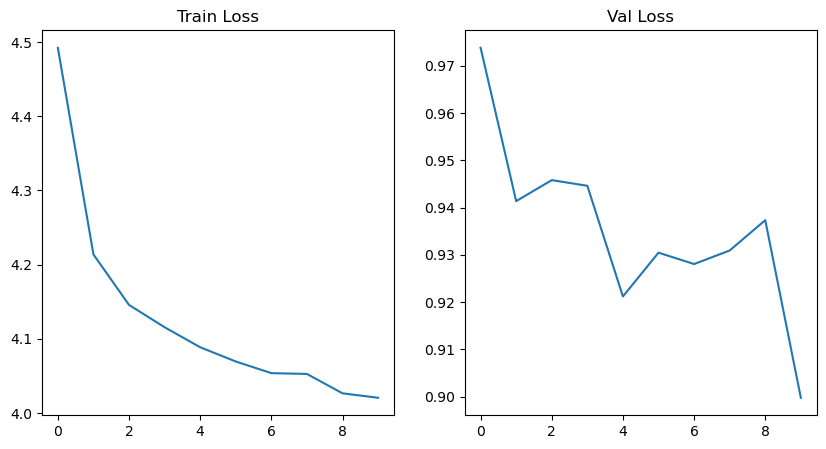

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(train_loss_history)
axes[0].set_title('Train Loss')
axes[1].plot(val_loss_history)
axes[1].set_title('Val Loss')

In [ ]:
def tsne_visualization(embeddings, labels, title="t-SNE Visualization"):

    
    embeddings = np.asarray(embeddings)
    labels = np.asarray(labels)
    
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    tsne_results = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='tab10', alpha=0.7, s=10)
    plt.colorbar(scatter, label='Classes')
    plt.title(title)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.grid(True, linestyle='--', alpha=0.5)
    
    plt.show()

In [ ]:
model.eval()

valloader = DataLoader(valset, batch_size=1, shuffle=False, num_workers=4)

embeddings = np.zeros((len(valloader), 2048))
labels = np.zeros(len(valloader))

with torch.no_grad():
    for i, (images, label, _) in enumerate(tqdm(valloader)):
        images, label = images.to(device), label.to(device)
        features = model(images)
        embeddings[i: (i + 1)] = features.cpu().numpy()
        labels[i: (i + 1)] = label.cpu().numpy()

  0%|          | 0/1199 [00:00<?, ?it/s]

100%|██████████| 1199/1199 [00:08<00:00, 136.81it/s]


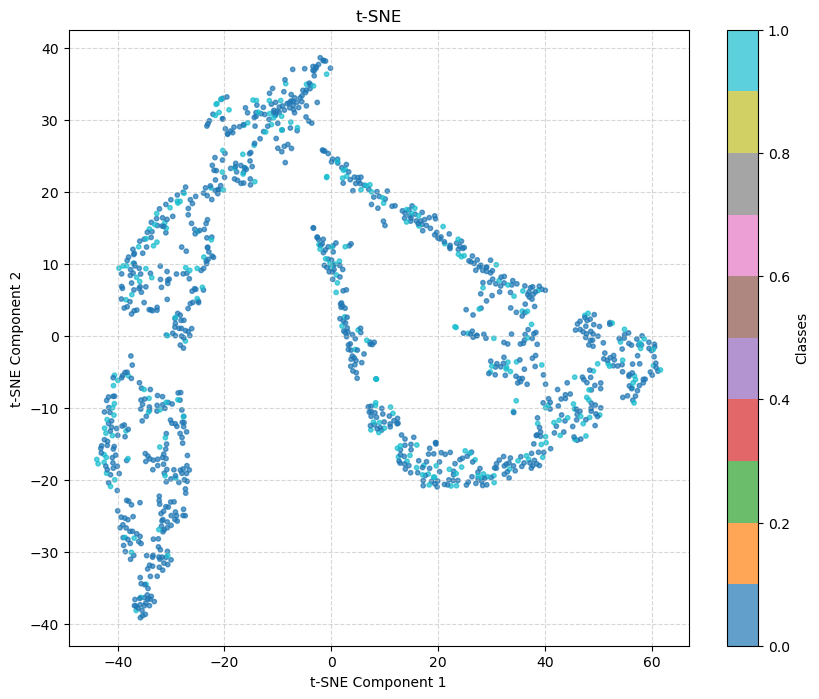

In [ ]:
tsne_visualization(embeddings, labels, title="t-SNE")

In [ ]:
model.fc = nn.Linear(2048, 2)
model.fc = model.fc.to(device)

for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)
train_accuracy = []
val_accuracy = []

trainloader, valloader = DataLoader(trainset, batch_size=256, shuffle=True, num_workers=4), DataLoader(valset, batch_size=256, shuffle=False, num_workers=4)

In [ ]:
for epoch in range(epochs):
    model.fc.train()
    train_loss = 0
    total_steps = 0
    correct = 0
    total = 0
    for i, (images, labels, _) in enumerate(tqdm(trainloader)):
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_steps +=1
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_accuracy.append(correct / total)    
    tqdm.write(f'Epoch: {epoch}, Loss: {train_loss / total_steps}, Accuracy: {correct / total}')

    model.eval()
    with torch.no_grad():
        val_loss = 0
        total_steps = 0
        correct = 0
        total = 0
        for i, (images, labels, _) in enumerate(valloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            total_steps += 1
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        val_accuracy.append(correct / total)
    
    tqdm.write(f'Epoch: {epoch}, Val Loss: {val_loss / total_steps}, Val Accuracy: {correct / total}')

100%|██████████| 19/19 [00:05<00:00,  3.79it/s]

Epoch: 0, Loss: 0.5883467934633556, Accuracy: 0.8456725755995829


Epoch: 0, Val Loss: 1.02121901512146, Val Accuracy: 0.6480400333611342


100%|██████████| 19/19 [00:05<00:00,  3.74it/s]

Epoch: 1, Loss: 0.41835264783156545, Accuracy: 0.9071949947862357


Epoch: 1, Val Loss: 1.120150375366211, Val Accuracy: 0.6213511259382819


100%|██████████| 19/19 [00:05<00:00,  3.67it/s]

Epoch: 2, Loss: 0.3849691999586005, Accuracy: 0.9113660062565172


Epoch: 2, Val Loss: 1.003879427909851, Val Accuracy: 0.5904920767306089


100%|██████████| 19/19 [00:05<00:00,  3.58it/s]

Epoch: 3, Loss: 0.37451881170272827, Accuracy: 0.910948905109489


Epoch: 3, Val Loss: 1.1376458883285523, Val Accuracy: 0.5896580483736447


100%|██████████| 19/19 [00:05<00:00,  3.56it/s]

Epoch: 4, Loss: 0.373435754525034, Accuracy: 0.9111574556830031


Epoch: 4, Val Loss: 0.9747466564178466, Val Accuracy: 0.5946622185154296


100%|██████████| 19/19 [00:05<00:00,  3.53it/s]

Epoch: 5, Loss: 0.3665042221546173, Accuracy: 0.9105318039624609


Epoch: 5, Val Loss: 1.0225395202636718, Val Accuracy: 0.591326105087573


100%|██████████| 19/19 [00:05<00:00,  3.68it/s]

Epoch: 6, Loss: 0.3637266049259587, Accuracy: 0.9099061522419186


Epoch: 6, Val Loss: 1.0893396139144897, Val Accuracy: 0.585487906588824


 53%|█████▎    | 10/19 [00:03<00:03,  2.57it/s]


KeyboardInterrupt: 